## ANN implementation for Page Blocks Classification

Processing paper documents is an important tasks in office automation. It involves much more than 
just a simple acquisition of a paper document by means of a scanner, Generally speaking, 
a paper document is a collection of printed objects (characters, columns, paragraphs, titles, 
figures, and so on), each of which needs to be detected and then processed in the most 
appropriate way. A segmentation process can quite accurately identify the different blocks 
in a document but it cannot identify them, i.e. it is not possible for the segmentation 
process to tell if a block is text or an image.

The problem is then to classify all the blocks of the page layout of a document that has been 
detected by a segmentation process. All blocks are manually labelled as image, text etc. 
on a historical dataset. The task is to use this historical dataset to predict the type of 
information contained in a block using artificial neural networks.

<em>Data Description</em><br>
The dataset contains information on 5,473 blocks identified from 54 documents.
1. height: height of the block.
2. length: length of the block.
3. area: Area of the block (height * length);
4. eccen: Eccentricity of the block (length / height);
5. p_black: Percentage of black pixels within the block (blackpix / area);
6. p_and: Percentage of black pixels after the application of the Run Length Smoothing Algorithm (RLSA) (blackand / area);
7. mean_tr: Mean number of white-black transitions (blackpix / wb_trans); 
8. blackpix: Total number of black pixels in the original bitmap of the block. 
9. blackand: Total number of black pixels in the bitmap of the block after the RLSA.
10. wb_trans: Number of white-black transitions in the original bitmap of the block.
11. Class: the class of the block. The five classes are: text (1), horizontal line (2), picture (3), vertical line (4) and graphic (5).

<em>Task:</em><br>
In the data folder, you are given 2 csv files train and test. We have split the original data i
n 2 partitions. Train your neural network on the train data set and evaluate the final model 
on the test split.

In [1]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf

import warnings
warnings.simplefilter("ignore")

In [2]:
# Note this code is only valid if GPU is being used for training

# Before we run the parameter tuning, we will work with little gpu memory allocation
# we will only use that much of memory of gpu as it is needed - allow the growth of gpu memory as it is needed

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

### Load and dataset and Validate data load

In [3]:
pageBlocks_train = pd.read_csv("./resources/page-blocks_train.csv")

pageBlocks_train.head()

,HEIGHT,LENGTH,AREA,ECCEN,P_BLACK,P_AND,MEAN_TR,BLACKPIX,BLACKAND,WB_TRANS,CLASS
0,9,111,999,12.333,0.209,0.571,1.57,209,570,133,1
1,6,14,84,2.333,0.286,1.000,1.20,24,84,20,1
2,9,34,306,3.778,0.320,0.886,1.56,98,271,63,1
3,8,12,96,1.500,0.427,0.719,2.73,41,69,15,1
4,1,288,288,288.000,0.424,1.000,1.02,122,288,120,2


In [4]:
# Check for missing values

pageBlocks_train.isna().sum()

HEIGHT      0
LENGTH      0
AREA        0
ECCEN       0
P_BLACK     0
P_AND       0
MEAN_TR     0
BLACKPIX    0
BLACKAND    0
WB_TRANS    0
CLASS       0
dtype: int64

There are no missing values in the dataset

In [6]:
# Check data structure and summary

pageBlocks_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4104 entries, 0 to 4103
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   HEIGHT    4104 non-null   int64  
 1   LENGTH    4104 non-null   int64  
 2   AREA      4104 non-null   int64  
 3   ECCEN     4104 non-null   float64
 4   P_BLACK   4104 non-null   float64
 5   P_AND     4104 non-null   float64
 6   MEAN_TR   4104 non-null   float64
 7   BLACKPIX  4104 non-null   int64  
 8   BLACKAND  4104 non-null   int64  
 9   WB_TRANS  4104 non-null   int64  
 10  CLASS     4104 non-null   int64  
dtypes: float64(4), int64(7)
memory usage: 352.8 KB


In [7]:
# Check summary statistics

pageBlocks_train.describe()

,HEIGHT,LENGTH,AREA,ECCEN,P_BLACK,P_AND,MEAN_TR,BLACKPIX,BLACKAND,WB_TRANS,CLASS
count,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000
mean,10.383041,89.329678,1136.501462,14.082265,0.368943,0.785938,6.630200,351.434698,723.096004,105.637183,1.206384
std,19.600668,114.908170,4384.188960,31.400576,0.179131,0.169647,79.356656,1226.521164,1808.160857,165.053263,0.726269
min,1.000000,1.000000,7.000000,0.007000,0.052000,0.062000,1.000000,7.000000,7.000000,1.000000,1.000000
25%,7.000000,17.000000,112.000000,2.143000,0.261000,0.680000,1.600000,42.000000,95.000000,17.000000,1.000000
50%,8.000000,41.000000,315.000000,5.167000,0.337000,0.803000,2.060000,106.000000,244.500000,48.000000,1.000000
75%,10.000000,107.000000,972.000000,13.723000,0.426000,0.927000,3.000000,280.250000,715.500000,125.000000,1.000000
max,804.000000,552.000000,142290.000000,537.000000,1.000000,1.000000,4955.000000,33017.000000,46133.000000,2925.000000,5.000000


### Exploratory Data Analysis

In [8]:
# Categories of the response variable
pageBlocks_train['CLASS'].unique()

array([1, 2, 4, 5, 3])

1    3674
2     255
5      87
4      68
3      20
Name: CLASS, dtype: int64


Text(0.5, 1.0, 'Proportion distribution various categories of CLASS')

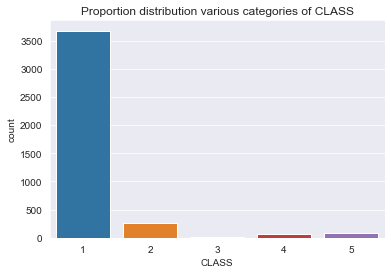

In [9]:
# Explore the response variable
print(pageBlocks_train['CLASS'].value_counts())
sns.countplot(x='CLASS', data=pageBlocks_train)
plt.title("Proportion distribution various categories of CLASS")

In [11]:
# We will write a function for repeated usage

def featureDistributionByResponse(feature, response):
    fig, axes = plt.subplots(nrows=1, ncols=5)
    sns.distplot(pageBlocks_train[pageBlocks_train[response] == 1][feature],ax=axes[0])
    axes[0].set_title('CLASS = 1')
    sns.distplot(pageBlocks_train[pageBlocks_train[response] == 2][feature],ax=axes[1])
    axes[1].set_title('CLASS = 2')
    sns.distplot(pageBlocks_train[pageBlocks_train[response] == 3][feature],ax=axes[2])
    axes[2].set_title('CLASS = 3')
    sns.distplot(pageBlocks_train[pageBlocks_train[response] == 4][feature],ax=axes[3])
    axes[3].set_title('CLASS = 4')
    sns.distplot(pageBlocks_train[pageBlocks_train[response] == 5][feature],ax=axes[4])
    axes[4].set_title('CLASS = 5')
    plt.tight_layout()

        count        mean         std   min    25%   50%     75%    max
CLASS                                                                  
1      3674.0    9.100980    4.914170   1.0   7.00   8.0   10.00   87.0
2       255.0    2.352941    3.927610   1.0   1.00   1.0    2.00   37.0
3        20.0  101.350000   61.160079  28.0  54.50  88.0  164.25  187.0
4        68.0   45.367647  109.774111   1.0   8.75  13.0   39.00  804.0
5        87.0   39.804598   54.850291   4.0   8.50  22.0   44.00  306.0


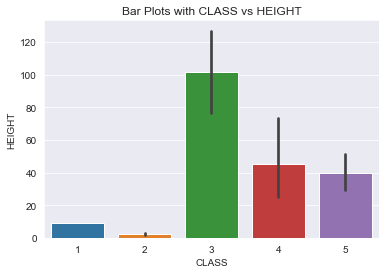

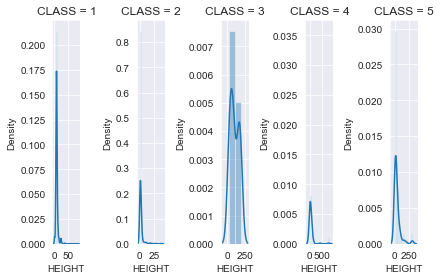

In [12]:
# Explore relationship with HEIGHT
print(pageBlocks_train.groupby('CLASS').describe()['HEIGHT'])
sns.barplot(x='CLASS',y='HEIGHT',data=pageBlocks_train)
plt.title("Bar Plots with CLASS vs HEIGHT")
# Distribution of HEIGHT by CLASS
featureDistributionByResponse('HEIGHT','CLASS')

        count        mean         std   min   25%    50%     75%    max
CLASS                                                                  
1      3674.0   87.438214  109.463895   1.0  18.0   41.0  105.00  536.0
2       255.0  139.878431  170.296906   1.0  19.0   63.0  190.00  552.0
3        20.0  150.900000  156.308703  31.0  45.5  100.0  151.25  547.0
4        68.0    2.382353    3.966386   1.0   1.0    1.0    2.00   25.0
5        87.0   74.850575  111.022052   1.0  10.5   29.0   69.50  465.0


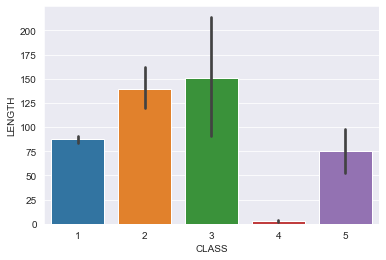

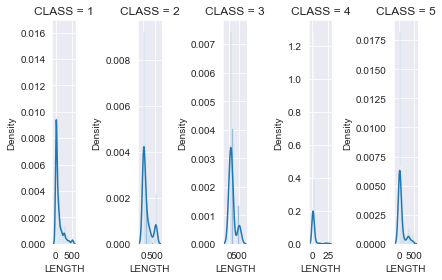

In [13]:
# Explore relationship with LENGTH

print(pageBlocks_train.groupby('CLASS').describe()['LENGTH'])
sns.barplot(x='CLASS',y='LENGTH',data=pageBlocks_train)
# Distribution of LENGTH by CLASS
featureDistributionByResponse('LENGTH','CLASS')

        count          mean           std    min     25%     50%       75%  \
CLASS                                                                        
0      3674.0    942.600708   1573.385373    7.0   132.0   336.0    986.25   
1       255.0    486.886275   1351.716229    7.0    28.0    73.0    280.50   
2        20.0  21125.400000  27393.877044  868.0  2669.5  9253.5  25775.00   
3        68.0    213.441176   1094.948051    7.0     9.0    18.0     59.50   
4        87.0   7355.275862  22441.062065    8.0    77.5   740.0   3255.00   

            max  
CLASS            
0       20867.0  
1       12240.0  
2       87234.0  
3        8844.0  
4      142290.0  


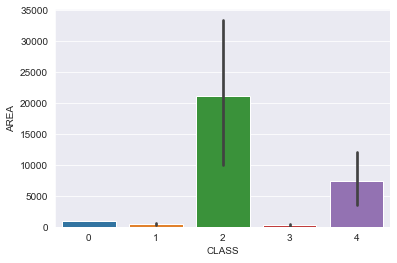

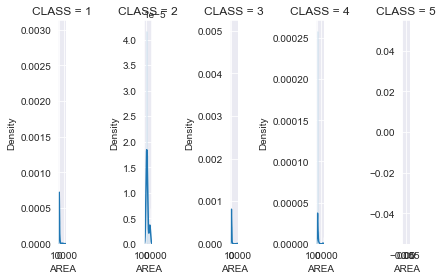

In [51]:
# Explore relationship with AREA
print(pageBlocks_train.groupby('CLASS').describe()['AREA'])
sns.barplot(x='CLASS',y='AREA',data=pageBlocks_train)
# Distribution of AREA by CLASS
featureDistributionByResponse('AREA','CLASS')

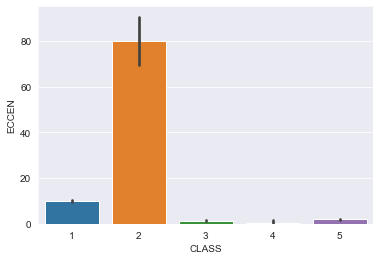

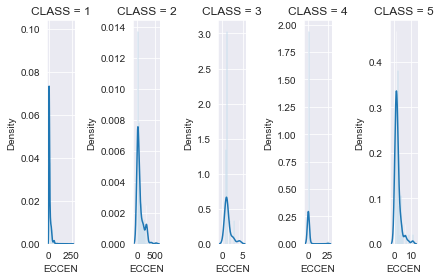

In [15]:
# Explore relationship with ECCEN
print(pageBlocks_train.groupby('CLASS').describe()['ECCEN'])
sns.barplot(x='CLASS',y='ECCEN',data=pageBlocks_train)
# Distribution of ECCEN by CLASS
featureDistributionByResponse('ECCEN','CLASS')

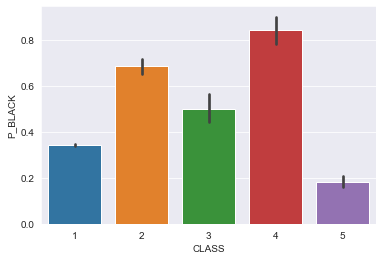

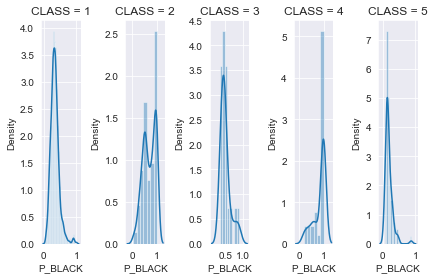

In [16]:
# Explore relationship with P_BLACK
print(pageBlocks_train.groupby('CLASS').describe()['P_BLACK'])
sns.barplot(x='CLASS',y='P_BLACK',data=pageBlocks_train)
# Distribution of P_BLACK by CLASS
featureDistributionByResponse('P_BLACK','CLASS')

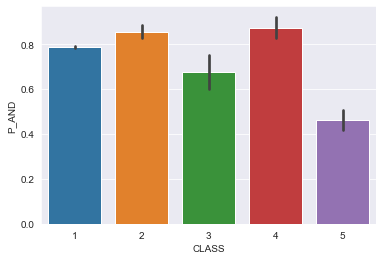

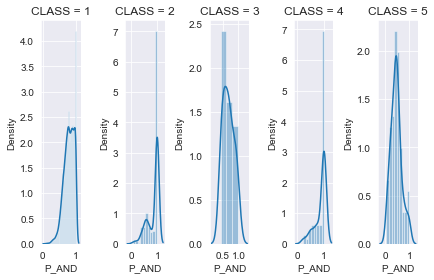

In [17]:
# Explore relationship with P_AND
print(pageBlocks_train.groupby('CLASS').describe()['P_AND'])
sns.barplot(x='CLASS',y='P_AND',data=pageBlocks_train)
# Distribution of P_AND by CLASS
featureDistributionByResponse('P_AND','CLASS')

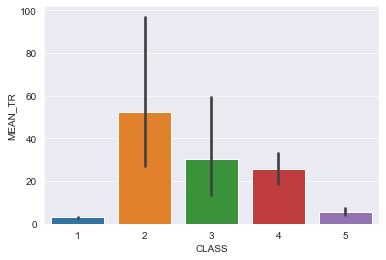

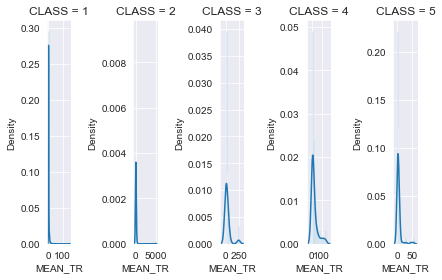

In [18]:
# Explore relationship with MEAN_TR
print(pageBlocks_train.groupby('CLASS').describe()['MEAN_TR'])
sns.barplot(x='CLASS',y='MEAN_TR',data=pageBlocks_train)
# Distribution of MEAN_TR by CLASS
featureDistributionByResponse('MEAN_TR','CLASS')

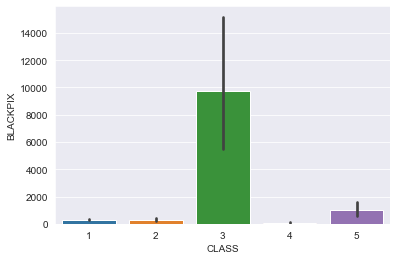

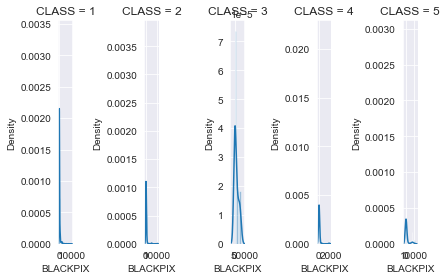

In [19]:
# Explore relationship with BLACKPIX
print(pageBlocks_train.groupby('CLASS').describe()['BLACKPIX'])
sns.barplot(x='CLASS',y='BLACKPIX',data=pageBlocks_train)
# Distribution of BLACKPIX by CLASS
featureDistributionByResponse('BLACKPIX','CLASS')

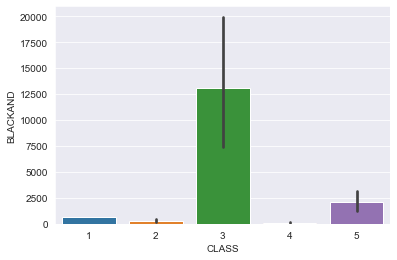

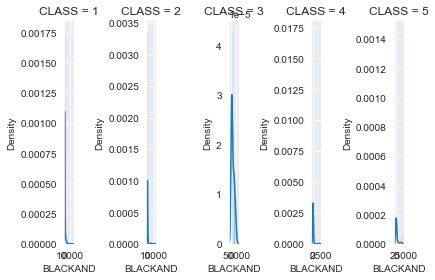

In [20]:
# Explore relationship with BLACKAND
print(pageBlocks_train.groupby('CLASS').describe()['BLACKAND'])
sns.barplot(x='CLASS',y='BLACKAND',data=pageBlocks_train)
# Distribution of BLACKAND by CLASS
featureDistributionByResponse('BLACKAND','CLASS')

        count        mean         std  min    25%    50%      75%     max
CLASS                                                                    
0      3674.0  108.930321  140.515327  1.0  21.00   56.0   136.00  1815.0
1       255.0   10.870588   28.570587  1.0   1.00    4.0     9.00   272.0
2        20.0  725.400000  771.635679  6.0  59.75  258.5  1482.75  2333.0
3        68.0    5.823529   16.426172  1.0   1.00    1.0     1.00   108.0
4        87.0  179.873563  438.644206  1.0   4.50   23.0   150.00  2925.0


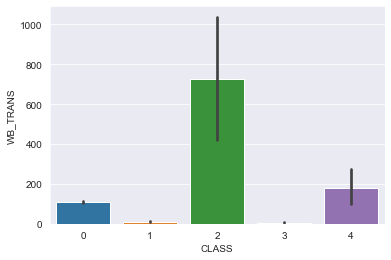

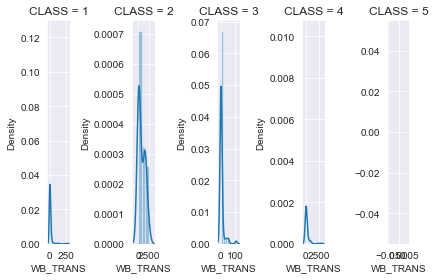

In [52]:
# Explore relationship with WB_TRANS
print(pageBlocks_train.groupby('CLASS').describe()['WB_TRANS'])
sns.barplot(x='CLASS',y='WB_TRANS',data=pageBlocks_train)
# Distribution of WB_TRANS by CLASS
featureDistributionByResponse('WB_TRANS','CLASS')

<AxesSubplot:>

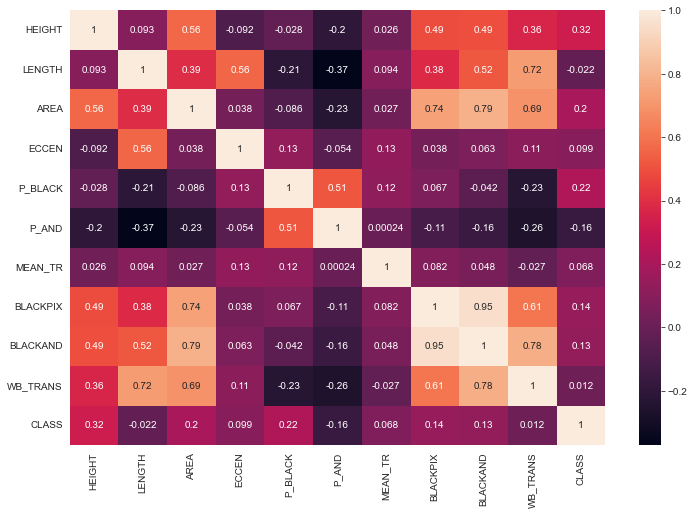

In [23]:
# Let's examine the correlation
plt.figure(figsize=(12, 8))
sns.heatmap(pageBlocks_train.corr(), annot=True)

### Data Preprocessing

In [24]:
# The target variable starts from 1 to 5 .. we need to make it start from 0

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

pageBlocks_train['CLASS'] = encoder.fit_transform(pageBlocks_train['CLASS'])

# Check encoding
pageBlocks_train['CLASS'].unique()

array([0, 1, 3, 4, 2])

In [25]:
# From the training set isolate the training features and training class
pageBlocks_train.columns

Index(['HEIGHT', 'LENGTH', 'AREA', 'ECCEN', 'P_BLACK', 'P_AND', 'MEAN_TR',
       'BLACKPIX', 'BLACKAND', 'WB_TRANS', 'CLASS'],
      dtype='object')

In [26]:
feature_cols = ['HEIGHT', 'LENGTH', 'AREA', 'ECCEN', 'P_BLACK', 'P_AND', 'MEAN_TR',
       'BLACKPIX', 'BLACKAND', 'WB_TRANS']
X_train = pageBlocks_train[feature_cols].values
y_train = pageBlocks_train['CLASS'].values

In [27]:
X_train[0]


array([9.0000e+00, 1.1100e+02, 9.9900e+02, 1.2333e+01, 2.0900e-01,
       5.7100e-01, 1.5700e+00, 2.0900e+02, 5.7000e+02, 1.3300e+02])

In [28]:
# We will perform feature scaling

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
print("Scaled Features in the training set")
print(X_train)

Scaled Features in the training set
[[-0.07056951  0.18861115 -0.03136685 ... -0.11614317 -0.08467978
   0.16580194]
 [-0.22364417 -0.65564404 -0.24009679 ... -0.26699466 -0.35349393
  -0.51890897]
 [-0.07056951 -0.48157081 -0.18945412 ... -0.20665406 -0.25006132
  -0.25835526]
 ...
 [-0.01954462  0.75434917  0.14223258 ... -0.02644769  0.13767267
   0.78385957]
 [-0.17261928 -0.61212574 -0.22891891 ... -0.25557887 -0.35349393
  -0.5007308 ]
 [-0.07056951 -0.45545982 -0.18329488 ... -0.17893    -0.24342394
  -0.24623648]]


In [29]:
# Check the first row of the training set
X_train[0]

array([-0.07056951,  0.18861115, -0.03136685, -0.05571485, -0.89299155,
       -1.26712415, -0.06377306, -0.11614317, -0.08467978,  0.16580194])

In [30]:
# Check the shape of X_train
X_train.shape

(4104, 10)

In [31]:
# Check the shape for y_train
y_train.shape

(4104,)

### Building the Neural Network

In [32]:
# NN Model Constants

INPUT_SHAPE = (X_train.shape[1], )
NUMBER_UNITS = 10
OUTPUT_UNITS = 5

HIDDEN_ACTIVATION = tf.keras.activations.relu
OUTPUT_ACTIVATION = tf.keras.activations.softmax

OPTIMIZER_FUNCTION = tf.keras.optimizers.Adam()
LOSS_FUNCTION = tf.keras.losses.SparseCategoricalCrossentropy()

METRICS_PARAM = ['accuracy']

NUMBER_EPOCHS = 100
BATCH_SIZE = 25

In [33]:
# build the ANN

classifier = tf.keras.models.Sequential()
classifier.add(tf.keras.layers.Dense(input_shape=INPUT_SHAPE, units=NUMBER_UNITS, activation=HIDDEN_ACTIVATION))
classifier.add(tf.keras.layers.Dense(units=NUMBER_UNITS, activation=HIDDEN_ACTIVATION))
classifier.add(tf.keras.layers.Dense(units=OUTPUT_UNITS, activation=OUTPUT_ACTIVATION))

# Check the model summary
classifier.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
Total params: 275
Trainable params: 275
Non-trainable params: 0
_________________________________________________________________


2022-07-14 17:01:48.198816: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
# Lets compile the ANN

classifier.compile(optimizer=OPTIMIZER_FUNCTION, loss=LOSS_FUNCTION, metrics=METRICS_PARAM)

In [35]:
# Training the model

epochs_hist = classifier.fit(X_train, y_train, epochs=NUMBER_EPOCHS, batch_size=BATCH_SIZE)

2022-07-14 17:01:53.790411: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/100
165/165 [==============================] - 0s 481us/step - loss: 1.1940 - accuracy: 0.7219
Epoch 2/100
165/165 [==============================] - 0s 467us/step - loss: 0.4861 - accuracy: 0.9131
Epoch 3/100
165/165 [==============================] - 0s 482us/step - loss: 0.3326 - accuracy: 0.9307
Epoch 4/100
165/165 [==============================] - 0s 482us/step - loss: 0.2893 - accuracy: 0.9274
Epoch 5/100
165/165 [==============================] - 0s 454us/step - loss: 0.2374 - accuracy: 0.9355
Epoch 6/100
165/165 [==============================] - 0s 466us/step - loss: 0.2035 - accuracy: 0.9436
Epoch 7/100
165/165 [==============================] - 0s 447us/step - loss: 0.1945 - accuracy: 0.9425
Epoch 8/100
165/165 [==============================] - 0s 450us/step - loss: 0.2005 - accuracy: 0.9388
Epoch 9/100
165/165 [==============================] - 0s 443us/step - loss: 0.1761 - accuracy: 0.9455
Epoch 10/100
165/165 [==============================] - 0s 455us/step - l

### Model Evaluation

In [36]:
epochs_hist.history.keys()

dict_keys(['loss', 'accuracy'])

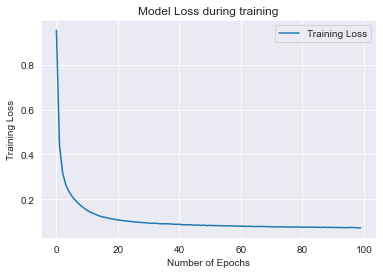

In [37]:
# Visualize the Model Loss
plt.plot(epochs_hist.history['loss'])
plt.title("Model Loss during training")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.legend(['Training Loss'])

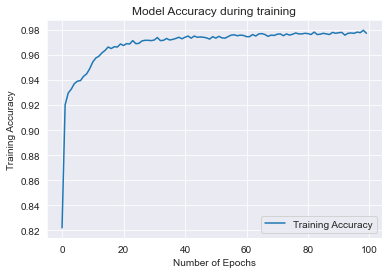

In [38]:
# Visualize the Model Accuracy
plt.plot(epochs_hist.history['accuracy'])
plt.title("Model Accuracy during training")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Accuracy")
plt.legend(['Training Accuracy'])

In [42]:
# Now we will load the test dataset

pageBlocks_test = pd.read_csv("./resources/page-blocks_test.csv")
# verify test data load
pageBlocks_test.head()

,HEIGHT,LENGTH,AREA,ECCEN,P_BLACK,P_AND,MEAN_TR,BLACKPIX,BLACKAND,WB_TRANS,CLASS
0,9,48,432,5.333,0.227,0.657,1.42,98,284,69,1
1,10,9,90,0.900,0.300,0.778,2.25,27,70,12,1
2,7,28,196,4.000,0.306,0.847,1.58,60,166,38,1
3,804,11,8844,0.014,0.191,0.233,15.64,1689,2058,108,4
4,8,31,248,3.875,0.371,0.782,2.00,92,194,46,1


In [43]:
# Quick Check for missing values

pageBlocks_test.isna().sum()

HEIGHT      0
LENGTH      0
AREA        0
ECCEN       0
P_BLACK     0
P_AND       0
MEAN_TR     0
BLACKPIX    0
BLACKAND    0
WB_TRANS    0
CLASS       0
dtype: int64

In [44]:
# We will use the same label encoder to transform the target variable in test data frame

pageBlocks_test['CLASS'] = encoder.transform(pageBlocks_test['CLASS'])

pageBlocks_test['CLASS'].unique()

array([0, 3, 4, 1, 2])

In [45]:
# Extract the test features and test target variables

X_test = pageBlocks_test[feature_cols].values
y_test = pageBlocks_test['CLASS'].values

In [46]:
# use the scaler object to scale the test features
X_test = sc.transform(X_test)

X_test

array([[-0.07056951, -0.35971954, -0.16071098, ..., -0.20665406,
        -0.24287082, -0.22199893],
       [-0.01954462, -0.69916235, -0.23872807, ..., -0.26454842,
        -0.36123754, -0.56738408],
       [-0.17261928, -0.53379278, -0.21454734, ..., -0.23763977,
        -0.30813845, -0.40983997],
       ...,
       [ 0.03148027, -0.48157081, -0.17394195, ..., -0.18789955,
        -0.21963997, -0.3431867 ],
       [-0.01954462, -0.56860743, -0.20451005, ..., -0.23437812,
        -0.29099187, -0.45225569],
       [-0.12159439, -0.40323785, -0.18078555, ..., -0.17648376,
        -0.22351178, -0.27047404]])

In [47]:
# Check the shape of the test features

X_test.shape

(1095, 10)

In [48]:
# Check the shape of the test target

y_test.shape

(1095,)

In [49]:
# We will run predictions now

y_preds = classifier.predict(X_test)

y_preds

array([[9.9980432e-01, 1.3384416e-05, 3.8660655e-06, 5.7973011e-06,
        1.7269696e-04],
       [9.8748636e-01, 7.0675608e-04, 4.7282897e-06, 9.7886572e-05,
        1.1704356e-02],
       [9.9934679e-01, 1.7943041e-04, 1.4000086e-07, 1.8416048e-06,
        4.7172201e-04],
       ...,
       [9.9942869e-01, 1.0262956e-04, 1.0144065e-06, 2.3464845e-06,
        4.6525663e-04],
       [9.9736905e-01, 1.9726485e-04, 1.6149557e-06, 8.5795546e-06,
        2.4234033e-03],
       [9.9993920e-01, 2.5265786e-05, 1.3118648e-07, 3.0637392e-07,
        3.5073423e-05]], dtype=float32)

In [50]:
# In order to use it in Confusion Matrix because it's a multiclass prediction

y_preds = np.argmax(y_preds, axis=1)

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

print('Confusion Matrix')
print(confusion_matrix(y_test, y_preds))
print("\n")
print("Accuracy Score")
print(accuracy_score(y_test, y_preds))
print("\n")
print("Classification Report")
print(classification_report(y_test, y_preds))

Confusion Matrix
[[974   6   0   0   4]
 [  6  57   0   2   0]
 [  0   0   7   0   0]
 [  2   0   0  13   0]
 [  5   1   0   0  18]]


Accuracy Score
0.9762557077625571


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       984
           1       0.89      0.88      0.88        65
           2       1.00      1.00      1.00         7
           3       0.87      0.87      0.87        15
           4       0.82      0.75      0.78        24

    accuracy                           0.98      1095
   macro avg       0.91      0.90      0.90      1095
weighted avg       0.98      0.98      0.98      1095

